In [2]:

!git clone -b EMT https://github.com/pop756/Quantum_KAN.git
%cd Quantum_KAN
!pip install -r requirements.txt

Cloning into 'Quantum_KAN'...
remote: Enumerating objects: 814, done.
remote: Counting objects: 100% (814/814), done.
remote: Compressing objects: 100% (758/758), done.
remote: Total 814 (delta 107), reused 740 (delta 53), pack-reused 0
Receiving objects: 100% (814/814), 17.85 MiB | 28.46 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/content/Quantum_KAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install qiskit_experiments

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.5/727.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 9.6 MB/s eta 0:00:00


In [4]:
# Configure JAX
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [6]:
import numpy as np

dim = 3

v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

In [7]:
from qiskit_dynamics import Solver

# build solver
dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
    array_library="jax",
)

In [8]:
from qiskit_dynamics import DynamicsBackend

# Consistent solver option to use throughout notebook
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}

backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[dim, dim], # for computing measurement data
    solver_options=solver_options, # to be used every time run is called
)

In [9]:
%%time

from qiskit import pulse

sigma = 128
num_samples = 256

schedules = []

for amp in np.linspace(0., 1., 10):
    gauss = pulse.library.Gaussian(
        num_samples, amp, sigma, name="Parametric Gauss"
    )

    with pulse.build() as schedule:
        with pulse.align_sequential():
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.shift_phase(0.5, pulse.DriveChannel(0))
            pulse.shift_frequency(0.1, pulse.DriveChannel(0))
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.acquire(duration=1, qubit_or_channel=0, register=pulse.MemorySlot(0))

    schedules.append(schedule)

job = backend.run(schedules, shots=100)
result = job.result()

CPU times: user 2.02 s, sys: 137 ms, total: 2.16 s
Wall time: 2.2 s


In [10]:
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate
from qiskit.circuit import Parameter
from qiskit.providers.backend import QubitProperties
from qiskit.circuit.library import HGate
from qiskit.transpiler import InstructionProperties

target = backend.target

# qubit properties
target.qubit_properties = [QubitProperties(frequency=v0), QubitProperties(frequency=v1)]

# add instructions
target.add_instruction(XGate(), properties={(0,): None, (1,): None})
target.add_instruction(SXGate(), properties={(0,): None, (1,): None})

target.add_instruction(CXGate(), properties={(0, 1): None, (1, 0): None})

# Add RZ instruction as phase shift for drag cal
phi = Parameter("phi")
with pulse.build() as rz0:
    pulse.shift_phase(phi, pulse.DriveChannel(0))
    pulse.shift_phase(phi, pulse.ControlChannel(1))

with pulse.build() as rz1:
    pulse.shift_phase(phi, pulse.DriveChannel(1))
    pulse.shift_phase(phi, pulse.ControlChannel(0))

target.add_instruction(
    RZGate(phi),
    {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
)

In [11]:
import pandas as pd
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

cals = Calibrations(libraries=[FixedFrequencyTransmon(basis_gates=['x', 'sx'])])

pd.DataFrame(**cals.parameters_table(qubit_list=[0,1, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,angle,(),sx,0.00,default,True,2024-06-10 11:01:26.129394+0000,None
1,β,(),x,0.00,default,True,2024-06-10 11:01:26.129350+0000,None
2,β,(),sx,0.00,default,True,2024-06-10 11:01:26.129386+0000,None
3,σ,(),sx,40.00,default,True,2024-06-10 11:01:26.129402+0000,None
4,angle,(),x,0.00,default,True,2024-06-10 11:01:26.129329+0000,None
5,duration,(),x,160.00,default,True,2024-06-10 11:01:26.129289+0000,None
6,duration,(),sx,160.00,default,True,2024-06-10 11:01:26.129367+0000,None
7,σ,(),x,40.00,default,True,2024-06-10 11:01:26.129359+0000,None
8,amp,(),sx,0.25,default,True,2024-06-10 11:01:26.129377+0000,None
9,amp,(),x,0.50,default,True,2024-06-10 11:01:26.129340+0000,None


In [12]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

# rabi experiments for qubit 0
rabi0 = RoughXSXAmplitudeCal([0], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

# rabi experiments for qubit 1
rabi1 = RoughXSXAmplitudeCal([1], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

In [13]:
%%time
rabi0_data = rabi0.run().block_for_results()
rabi1_data = rabi1.run().block_for_results()

CPU times: user 12.6 s, sys: 504 ms, total: 13.1 s
Wall time: 18.6 s


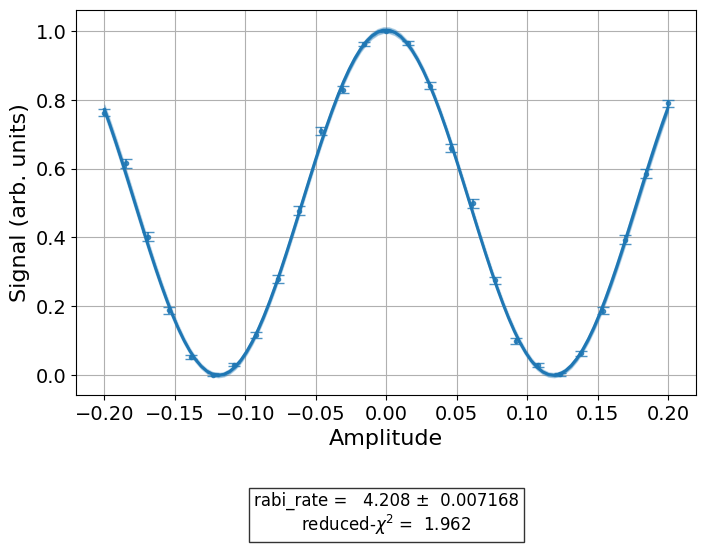

In [14]:
rabi0_data.figure(0)

In [15]:
# set the control channel map
backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})

In [16]:
pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()], parameters="amp"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,"(0,)",sx,0.059407,default,True,2024-06-10 11:01:39.917752+0000,818a7d0f-e71c-4de0-bf47-260ae8f3527d
1,amp,(),x,0.500000,default,True,2024-06-10 11:01:26.129340+0000,None
2,amp,(),sx,0.250000,default,True,2024-06-10 11:01:26.129377+0000,None
3,amp,"(0,)",x,0.118814,default,True,2024-06-10 11:01:39.917752+0000,818a7d0f-e71c-4de0-bf47-260ae8f3527d


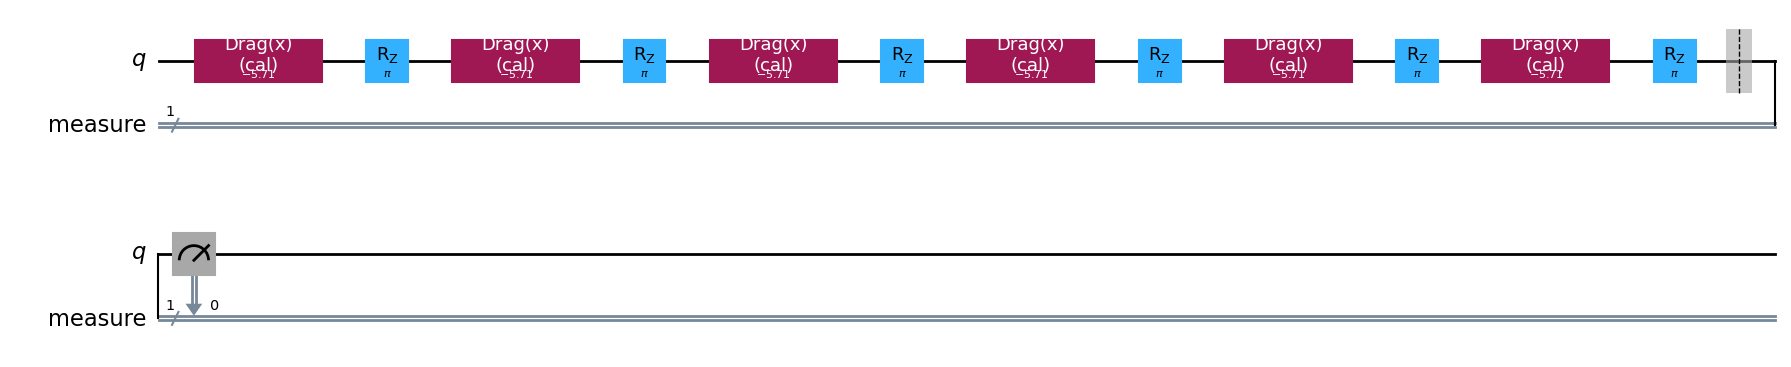

In [17]:
from qiskit_experiments.library.calibration import RoughDragCal

cal_drag0 = RoughDragCal([0], cals, backend=backend, betas=np.linspace(-20, 20, 15))
cal_drag1 = RoughDragCal([1], cals, backend=backend, betas=np.linspace(-20, 20, 15))

cal_drag0.set_experiment_options(reps=[3, 5, 7])
cal_drag1.set_experiment_options(reps=[3, 5, 7])

cal_drag0.circuits()[5].draw(output="mpl")

In [18]:
%%time
drag0_data = cal_drag0.run().block_for_results()
drag1_data = cal_drag1.run().block_for_results()

CPU times: user 51 s, sys: 7.62 s, total: 58.6 s
Wall time: 52.9 s


In [19]:
pd.DataFrame(**cals.parameters_table(qubit_list=[1, ()], parameters="amp"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,"(1,)",x,0.100316,default,True,2024-06-10 11:01:50.588516+0000,36d6c04c-675b-4a04-af57-d0bff7a0a818
1,amp,"(1,)",sx,0.050158,default,True,2024-06-10 11:01:50.588516+0000,36d6c04c-675b-4a04-af57-d0bff7a0a818
2,amp,(),x,0.500000,default,True,2024-06-10 11:01:26.129340+0000,None
3,amp,(),sx,0.250000,default,True,2024-06-10 11:01:26.129377+0000,None


In [20]:
# set the control channel map
backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})

In [270]:
from qiskit.pulse import Schedule
from qiskit.pulse import Play, DriveChannel, ControlChannel,Drag
from qiskit.pulse import Gaussian,GaussianSquare
from qiskit.circuit.library import ECRGate
duration = 500
sched_CNOT = Schedule(Play(GaussianSquare(duration=duration, sigma=64, width=duration/2, amp=0.05, angle=0.0),ControlChannel(0)))
sched_CNOT += Schedule((duration, Play(Drag(duration=160, sigma=40, beta=-1.6184263945, amp=0.11881449, angle=0), DriveChannel(0))), name="circuit-614")
sched_CNOT += Schedule((160,Play(GaussianSquare(duration=duration, sigma=64, width=duration/2, amp=0.05, angle=3.14),ControlChannel(0))))


sched_CNOT_1 = Schedule(Play(GaussianSquare(duration=duration, sigma=64, width=duration/2, amp=0.05, angle=0),ControlChannel(0)))
sched_CNOT_1 += Schedule((duration, Play(Drag(duration=160, sigma=40, beta=-1.6184263945, amp=0.11881449, angle=3.14), DriveChannel(0))), name="circuit-614")
sched_CNOT_1 += Schedule((160,Play(GaussianSquare(duration=duration, sigma=64, width=duration/2, amp=0.05, angle=3.14),ControlChannel(0))))

sched_CNOT +=sched_CNOT_1
"""
target.add_instruction(
    ECRGate(),
    {(0,1): InstructionProperties(calibration=sched_CNOT)}
)"""

'\ntarget.add_instruction(\n    ECRGate(),\n    {(0,1): InstructionProperties(calibration=sched_CNOT)}\n)'

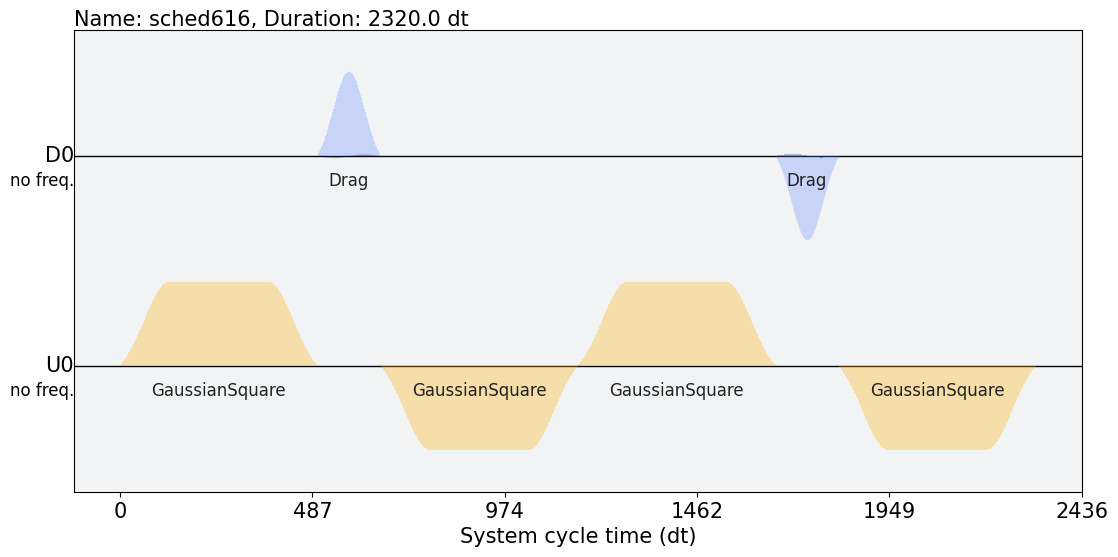

In [271]:
sched_CNOT.draw()

In [272]:
target.update_instruction_properties(
    'ecr',
    (0,1),
    InstructionProperties(calibration=sched_CNOT)
)

In [273]:
sch.instructions[2]

(1000,
 Play(GaussianSquare(duration=500, sigma=64, width=250.0, amp=0.05, angle=0), ControlChannel(0)))

In [274]:
sch = target['ecr'][(0,1)].calibration

In [275]:
from qiskit_experiments.library import CrossResonanceHamiltonian

backend.target.update_from_instruction_schedule_map(cals.get_inst_map())

In [283]:
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
circ2 = QuantumCircuit(2,2)
circ2.h(0)
circ2.s(0)
circ2.ecr(0,1)
circ2.sdg(0)
circ2.h(0)
circ2.measure([0,1], [0,1])
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=[0,1])
circ2 = passmanager.run(circ2)
%time result = backend.run(circ2).result()

CPU times: user 2.29 s, sys: 12.4 ms, total: 2.31 s
Wall time: 4.11 s


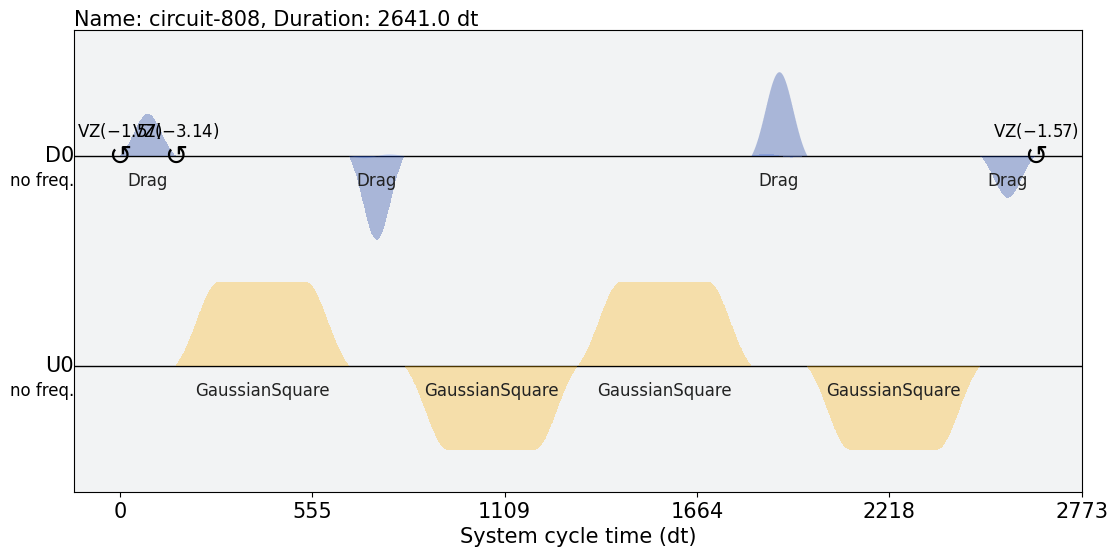

In [284]:
from qiskit import schedule as build_schedule  # Rename the import

build_schedule(circ2, backend=backend).draw()  # Call the function using the new name

In [285]:
result.get_counts(0)

{'00': 1024}

In [67]:
from qiskit import pulse,schedule
schedule(cr_ham_experiment.circuits()[4],backend=backend)

Schedule((0, Play(Drag(duration=160, sigma=40, beta=-1.6019642677, amp=0.11834026, angle=0), DriveChannel(0))), (160, Delay(450, DriveChannel(0))), (160, Delay(450, DriveChannel(1))), (160, Play(GaussianSquare(duration=450, sigma=64, width=194, amp=0.5, angle=0.0), ControlChannel(0))), (610, Play(Drag(duration=160, sigma=40, beta=0, amp=0.05022207, angle=0), DriveChannel(1))), (770, Acquire(1, AcquireChannel(1), MemorySlot(0))), name="circuit-2121")

In [29]:
%time data_cr = cr_ham_experiment.run().block_for_results()

CPU times: user 28.6 s, sys: 2.83 s, total: 31.4 s
Wall time: 31.3 s


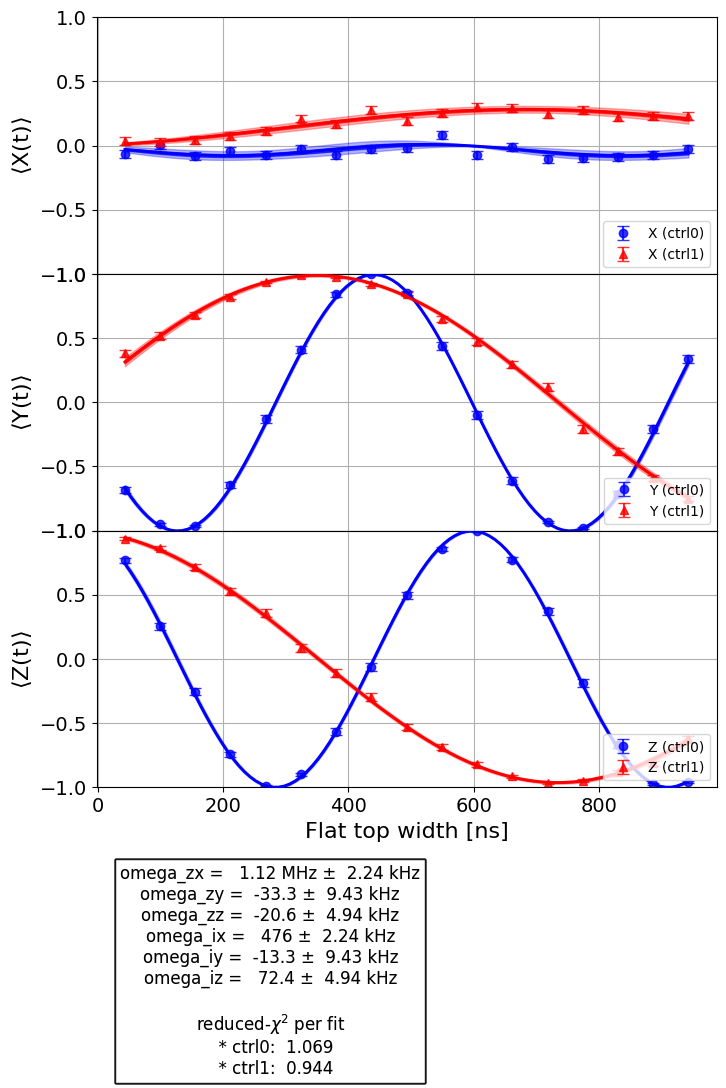

In [30]:
data_cr.figure(0)
